# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [37]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Portfolio data set

In [39]:
print("Number of portfolio data: {}".format(portfolio.shape[0]))

Number of portfolio data: 10


In [40]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


There is three kinds of offer type:

* bogo
* informational
* discount

For channels, we have:

* web
* email
* mobile
* social

It is expected that different channel might have different influence on users. However, given the data set has multiple variables, I will try to bundle them together and not look at a specific variable.

### Profile data set

In [41]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [42]:
print("Number of profile data: {}".format(profile.shape[0]))

Number of profile data: 17000


We have 17000 customer data set. The data seems incomplete because some data contains 118 for age, None for gender and NaN for income. Let's take a look at distribution of each features.

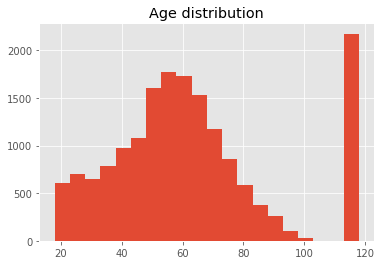

In [43]:
profile['age'].fillna(200).hist(bins=20)
plt.title('Age distribution')
plt.show()

This shows there is a lot more people who is 118 years, which seems not realistic. It's most likely is the default value for the profile. I will replace this value with the average in the data preprocessing phase.

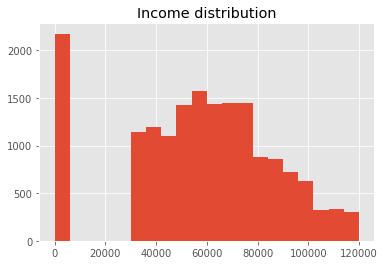

In [44]:
profile['income'].fillna(0).hist(bins=20)
plt.title('Income distribution')
plt.show()

The distribution of income seems reasonably distributed given it looks like normal distribution except for some NaN objects. This needs to be filled with average value.

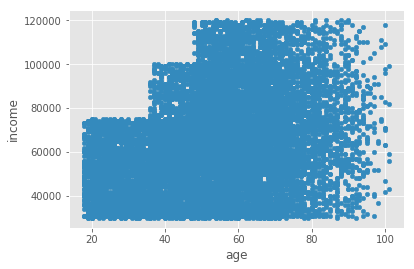

In [45]:
plt.style.use('ggplot')
profile.plot.scatter(x = 'age', y = 'income')
plt.show()

However, there is income cut off for each age groups as shown above. For people in 20s and 30s somewhere around 750K is a cut off for example. This indicates that the profile data is arbitrarily created. This may make prediciton simpler because user segmentation is clearler. 

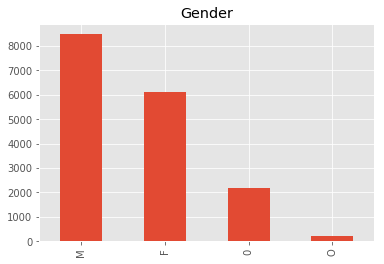

In [46]:
profile['gender'].fillna(0).value_counts().plot(kind='bar', title='Gender')
plt.show()

In [47]:
profile['became_member_on'].isnull().sum()

0

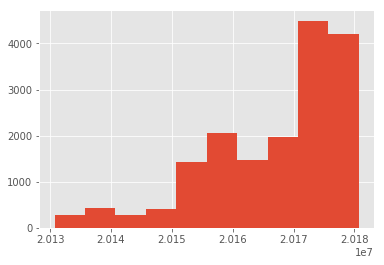

In [48]:
profile['became_member_on'].hist()
plt.show()

This column seems reasonable because number of people who became member in a year is increasing year by year.

### Transcript data set

In [49]:
print("Number of transcript data: {}".format(transcript.shape[0]))

Number of transcript data: 306534


In [91]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


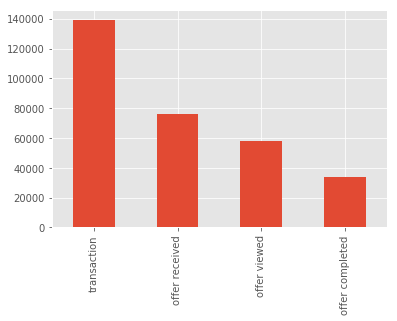

In [51]:
transcript['event'].value_counts().plot(kind='bar')
plt.show()

There is four types of events. Transaction, offer recieved and offer completed. They are reasonably balanced.

In [52]:
print('Value for transaction: {}'.format(transcript[transcript['event']=='transaction'].iloc[0]['value']))
print('Value for offer received: {}'.format(transcript[transcript['event']=='offer received'].iloc[0]['value']))
print('Value for offer viewed: {}'.format(transcript[transcript['event']=='offer viewed'].iloc[0]['value']))
print('Value for offer completed: {}'.format(transcript[transcript['event']=='offer completed'].iloc[0]['value']))

Value for transaction: {'amount': 0.8300000000000001}
Value for offer received: {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
Value for offer viewed: {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
Value for offer completed: {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}


In [53]:
transaction = transcript[transcript['event']=='transaction'].copy()
offer = transcript[transcript['event']!='transaction'].copy()

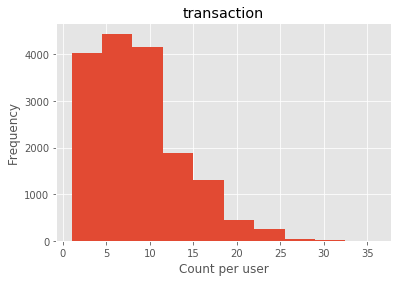

In [95]:
transaction.person.value_counts().plot(kind='hist', title='transaction')
plt.xlabel("Count per user")
plt.show()

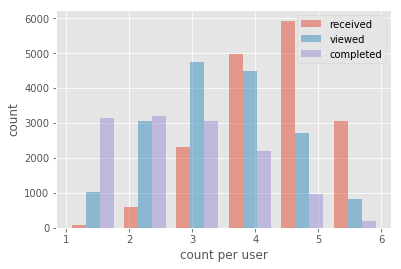

In [94]:
data1 = offer[offer['event']=='offer received'].person.value_counts()
data2 = offer[offer['event']=='offer viewed'].person.value_counts()
data3 = offer[offer['event']=='offer completed'].person.value_counts()

plt.hist([data1, data2, data3], alpha = 0.5, bins=6)
plt.legend(['received', 'viewed', 'completed'])
plt.xlabel('count per user')
plt.ylabel('count')
plt.show()

In [56]:
print("# offer received: {}, # offer completed: {}".format(len(offer[offer['event']=='offer received']), len(offer[offer['event']=='offer completed'])))

# offer received: 76277, # offer completed: 33579


The data set is balanced since out of 76277 offer received, 33579 was completed which is about the half.

### What we've learned from data data exploration
* Profile
    * Use cuustomer id for indexing customer data
    * Replace NaN with average for age 
* Transaction
    * Separate transaction data into for separate data frame
    * Extract value dictionary in transaction data to fiieds

## Data cleanup

In [57]:
def clean_portfolio(data):
    p = data.copy()
    p['web'] = p['channels'].apply(lambda x: 1 if 'web' in x else 0)
    p['email'] = p['channels'].apply(lambda x: 1 if 'email' in x else 0)
    p['mobile'] = p['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    p['social'] = p['channels'].apply(lambda x: 1 if 'social' in x else 0)
    p.drop(['channels'], axis=1, inplace=True)
    
    p['bogo'] = p['offer_type'].apply(lambda x: 1 if 'bogo' in x else 0)
    p['discount'] = p['offer_type'].apply(lambda x: 1 if 'discount' in x else 0)
    p['informational'] = p['offer_type'].apply(lambda x: 1 if 'informational' in x else 0)
    p.drop(['offer_type'], axis=1, inplace=True)
    
    p['offer_id'] = p['id']
    p.set_index('offer_id', inplace=True)
    p.drop(['id'], axis=1, inplace=True)
    
    return p

In [58]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,1,0,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,1,0,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0


In [59]:
import datetime

def clean_profile(df):
    p = df.copy()
    p['age'] = p['age'].apply(lambda x: np.nan if x == 118 else x)
    p['age'] = p['age'].fillna(p['age'].mean())
    
    p['income'] = p['income'].fillna(p['income'].mean())
    
    p['male'] = p['gender'].apply(lambda x: 1 if x == 'M' else 0)
    p['female'] = p['gender'].apply(lambda x: 1 if x == 'F' else 0)
    p['no_gender'] = p['gender'].apply(lambda x: 1 if x != 'F' and x != 'M' else 0)
    p.drop(['gender'], axis=1, inplace=True)

    p['profile_id'] = p['id']
    p.drop(['id'], axis=1, inplace=True)
    p.set_index('profile_id',inplace=True)

    p['member_days'] = (datetime.datetime.today().date() - pd.to_datetime(p['became_member_on'], format='%Y%m%d').dt.date).dt.days
    p.drop(['became_member_on'], axis=1, inplace=True)
    return p

In [60]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,income,male,female,no_gender,member_days
profile_id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,54.393524,65404.991568,0,0,1,1102
0610b486422d4921ae7d2bf64640c50b,55.000000,112000.000000,0,1,0,949
38fe809add3b4fcf9315a9694bb96ff5,54.393524,65404.991568,0,0,1,587
78afa995795e4d85b5d9ceeca43f5fef,75.000000,100000.000000,0,1,0,1016
a03223e636434f42ac4c3df47e8bac43,54.393524,65404.991568,0,0,1,929


In [61]:
import re

def clean_transaction(df):
    d = df.copy()
    d['profile_id'] = d['person']
    d.drop(['person'], axis = 1, inplace = True)

    d['amount'] = d['value'].apply(lambda x: x['amount'])
    d.drop(['value'], axis = 1, inplace = True)
    d.drop(['time'], axis = 1, inplace = True)
    d.drop(['event'], axis = 1, inplace = True)
    
    d.reset_index(drop=True, inplace = True)
    return d

def clean_offer(df):
    d = df.copy()
    d['profile_id'] = d['person']
    d.drop(['person'], axis = 1, inplace = True)
    
    d['offer_id'] = d['value'].apply(lambda x: x['offer id'] if 'offer id' in x.keys() else x['offer_id'] if 'offer_id' in x.keys() else np.nan)

    d['event'] = d['event'].apply(lambda x: x.replace(" ", "_"))                                 
    event_df = pd.get_dummies(d['event'])    
    d = pd.concat([d, event_df], axis=1)

    d.drop(['value', 'time', 'event'], axis = 1, inplace = True)
    d.reset_index(drop=True, inplace = True)
    return d

In [62]:
cleaned_transaction = clean_transaction(transaction)
cleaned_transaction.head()

,profile_id,amount
0,02c083884c7d45b39cc68e1314fec56c,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
2,54890f68699049c2a04d415abc25e717,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [63]:
cleaned_offer = clean_offer(offer)
cleaned_offer.head()

,profile_id,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [64]:
merged_data = pd.merge(cleaned_offer, cleaned_portfolio, on='offer_id')
merged_data = pd.merge(merged_data, cleaned_profile, on='profile_id')

columns = merged_data.columns
columns.to_list()

offer_columns = ['offer_completed', 'offer_received', 'offer_viewed']

agg_func={}
for x in columns:
    if x in offer_columns:
        agg_func[x] = "sum"
    elif x not in ['profile_id', 'offer_id']:
        agg_func[x] = "mean"

grouped_data = merged_data.groupby(['profile_id', 'offer_id']).agg(agg_func)

grouped_data['offer_completed'] = grouped_data['offer_completed'].apply(lambda x: 1 if x > 0.0 else 0)

grouped_data.reset_index(inplace=True, drop=True)

offer_received = grouped_data['offer_received']
offer_viewed = grouped_data['offer_viewed']
offer_completed = grouped_data['offer_completed']

X = grouped_data.drop([
    'offer_completed', 
    'offer_received',
    'offer_viewed',], axis = 1)

In [65]:
X.head()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational,age,income,male,female,no_gender,member_days
0,10,7,2,1,1,1,0,0,1,0,33.0,72000.0,1,0,0,1034
1,0,4,0,1,1,1,0,0,0,1,33.0,72000.0,1,0,0,1034
2,0,3,0,0,1,1,1,0,0,1,33.0,72000.0,1,0,0,1034
3,5,5,5,1,1,1,1,1,0,0,33.0,72000.0,1,0,0,1034
4,10,10,2,1,1,1,1,0,1,0,33.0,72000.0,1,0,0,1034


In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'income', 'difficulty','duration', 'reward','member_days']

X[numerical] = scaler.fit_transform(X[numerical])
X.head()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational,age,income,male,female,no_gender,member_days
0,0.50,0.571429,0.2,1,1,1,0,0,1,0,0.180723,0.466667,1,0,0,0.25288
1,0.00,0.142857,0.0,1,1,1,0,0,0,1,0.180723,0.466667,1,0,0,0.25288
2,0.00,0.000000,0.0,0,1,1,1,0,0,1,0.180723,0.466667,1,0,0,0.25288
3,0.25,0.285714,0.5,1,1,1,1,1,0,0,0.180723,0.466667,1,0,0,0.25288
4,0.50,1.000000,0.2,1,1,1,1,0,1,0,0.180723,0.466667,1,0,0,0.25288


In [67]:
from sklearn.model_selection import train_test_split
def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=1)
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = split_data(X, offer_completed, 0.2)

# Train The Benchmark Model

In [69]:
import sagemaker
import os
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer


In [70]:
import os

def save_to_s3(data_dir, X_train, X_test, y_train, y_test):
    pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
    pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [71]:
data_dir = '../data/xgboost'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
save_to_s3(data_dir, X_train, X_test, y_train, y_test)

In [73]:
prefix = 'starbucks'
session = sagemaker.Session()

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [74]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
training_data = {'train': s3_input_train}

In [76]:
output_path = 's3://{}/{}/output'.format(session.default_bucket(), prefix)

In [77]:
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri


def xgb_predictor(training_data, output_path):
    container = get_image_uri(session.boto_region_name, 'xgboost')
    
    xgb = sagemaker.estimator.Estimator(container,
    get_execution_role(),
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path=output_path,
    sagemaker_session=session)
    
    xgb.set_hyperparameters(max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective='binary:logistic',
    early_stopping_rounds=10,
    num_round=500)
    
    xgb.fit(training_data)
    
    return xgb


In [78]:
xgb = xgb_predictor(training_data, output_path)

	get_image_uri(region, 'xgboost', '0.90-1').


2020-02-19 01:02:09 Starting - Starting the training job...
2020-02-19 01:02:14 Starting - Launching requested ML instances......
2020-02-19 01:03:39 Starting - Preparing the instances for training.........
2020-02-19 01:04:44 Downloading - Downloading input data...
2020-02-19 01:05:38 Training - Training image download completed. Training in progress..Arguments: train
[2020-02-19:01:05:38:INFO] Running standalone xgboost training.
[2020-02-19:01:05:38:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-02-19:01:05:38:INFO] File size need to be processed in the node: 5.26mb. Available memory size in the node: 8517.38mb
[2020-02-19:01:05:38:INFO] Determined delimiter of CSV input is ','
[01:05:38] S3DistributionType set as FullyReplicated
[01:05:38] 50630x16 matrix with 810080 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[01:05:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[0]#011


2020-02-19 01:05:55 Uploading - Uploading generated training model
2020-02-19 01:05:55 Completed - Training job completed
Training seconds: 71
Billable seconds: 71


## Testing The model

In [83]:
from sklearn.metrics import accuracy_score

def test_model(model, test_location, X_test, y_test):
    transformer = model.transformer(instance_count=1, instance_type = 'ml.m4.xlarge')
    transformer.transform(test_location, content_type='text/csv', split_type='Line')
    transformer.wait()
    
    !aws s3 cp --recursive $transformer.output_path $data_dir
    
    y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
    y_pred = [round(num) for num in y_pred.squeeze().values]
    
    print('Accuracy score: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    
    return y_pred

In [84]:
xgb_prediction = test_model(xgb, test_location, X_test, y_test)

....................Arguments: serve
[2020-02-19 04:45:51 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-02-19 04:45:51 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-02-19 04:45:51 +0000] [1] [INFO] Using worker: gevent
[2020-02-19 04:45:51 +0000] [38] [INFO] Booting worker with pid: 38
[2020-02-19 04:45:51 +0000] [39] [INFO] Booting worker with pid: 39
[2020-02-19 04:45:51 +0000] [40] [INFO] Booting worker with pid: 40
[2020-02-19:04:45:51:INFO] Model loaded successfully for worker : 38
[2020-02-19:04:45:51:INFO] Model loaded successfully for worker : 39
[2020-02-19 04:45:51 +0000] [41] [INFO] Booting worker with pid: 41
[2020-02-19:04:45:51:INFO] Model loaded successfully for worker : 40
[2020-02-19:04:45:51:INFO] Model loaded successfully for worker : 41

[2020-02-19:04:46:05:INFO] Sniff delimiter as ','
[2020-02-19:04:46:05:INFO] Determined delimiter of CSV input is ','
[2020-02-19:04:46:05:INFO] Sniff delimiter as ','
[2020-02-19:04:46:05:INFO] Determined delimit

## More models

In [85]:
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def train_predict(model, X_train, y_train, X_test, y_test):
    print('Name: {}'.format(model.__class__.__name__))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = model.score(X_test, y_test)
    print('Test score: {:.3f}'.format(score))
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy score: {:.3f}'.format(accuracy))

    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.2f' % auc)
    fpr, tpr, _ = roc_curve(y_test, probs)
    
    return {'y_pred': y_pred, 'auc': auc, 'fpr': fpr, 'tpr': tpr, 'score': score, 'accuracy': accuracy}

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

models = []
models.append(SVC(probability=True))
models.append(MLPClassifier())
models.append(LogisticRegression())
models.append(KNeighborsClassifier())
models.append(SVC(kernel='linear',probability=True))
models.append(RandomForestClassifier())
models.append(AdaBoostClassifier())


Name: SVC


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test score: 0.767
Accuracy score: 0.767
AUC: 0.86
Name: MLPClassifier


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test score: 0.784
Accuracy score: 0.784
AUC: 0.88
Name: LogisticRegression


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test score: 0.765
Accuracy score: 0.765
AUC: 0.85
Name: KNeighborsClassifier
Test score: 0.764
Accuracy score: 0.764
AUC: 0.84
Name: SVC
Test score: 0.766
Accuracy score: 0.766
AUC: 0.85
Name: RandomForestClassifier


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score: 0.763
Accuracy score: 0.763
AUC: 0.85
Name: AdaBoostClassifier
Test score: 0.782
Accuracy score: 0.782
AUC: 0.88


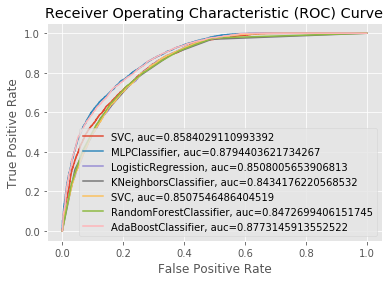

---------------------------------
best_method： MLPClassifier
best_score： 0.7836941064939169


In [88]:
best_score = 0
best_method = ""

for model in models:
    result = train_predict(model, X_train, y_train, X_test, y_test)
    fpr, tpr, auc = result['fpr'], result['tpr'], result['auc']
    plt.plot(fpr,tpr,label="{}, auc={}".format(model.__class__.__name__, str(auc)))
    
    if result['score'] > best_score:
        best_method = model.__class__.__name__
        best_score = result['score']

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print('---------------------------------')
print('best_method：', best_method)
print('best_score：', best_score)


# Clean up

In [96]:
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))